In [1]:
%matplotlib inline
import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import tensorflow.contrib.layers as layers
import tensorflow.contrib.slim as slim
from random import shuffle

In [2]:
total_azimuth_angles = 36
train_split = 0.8
image_H, image_W, image_D = 64,64,3

In [3]:
dataset = np.load('../datasets/car_64.npy')


1553596416


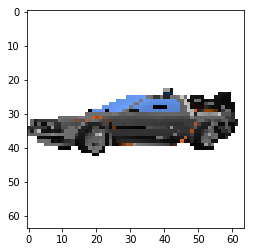

In [4]:
print(dataset.nbytes)
plt.imshow(dataset[1111]/255)
plt.show()

In [5]:
 
total_models = dataset.shape[0] // total_azimuth_angles


train_models_len = int(total_models * train_split)
test_models_len = total_models - train_models_len

print(total_models,train_models_len,test_models_len)

3512 2809 703


In [6]:
dataset_train = dataset[:train_models_len*total_azimuth_angles]
dataset_test = dataset[train_models_len*total_azimuth_angles:]

print(dataset_test.shape)
print(dataset_train.shape)

(25308, 64, 64, 3)
(101124, 64, 64, 3)


In [7]:
del dataset
dataset_train.nbytes

1242611712

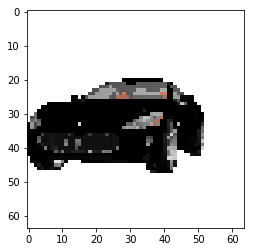

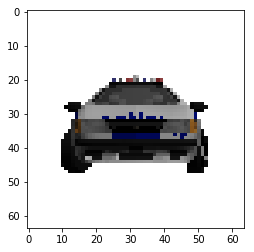

In [8]:
plt.imshow(dataset_train[101123]/255)
plt.show()
plt.imshow(dataset_test[36]/255)
plt.show()

In [9]:
train_pairs = []
start_pose = [0]
for i in range(train_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                train_pairs.append((i,j,k))
                
test_pairs = []
start_pose = [0,9,18,27]
for i in range(test_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                test_pairs.append((i,j,k))


In [10]:
print(train_pairs[35])
print(test_pairs[35])
shuffle(train_pairs)
shuffle(test_pairs)
print(train_pairs[35])
print(test_pairs[35])

(1, 0, 1)
(0, 9, 0)
(2167, 0, 21)
(429, 18, 22)


(199, 0, 16)
(620, 27, 2)
98315


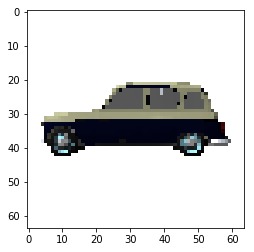

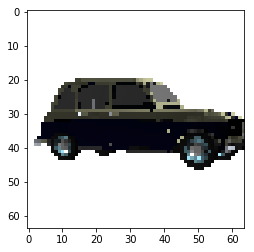

In [11]:
print(train_pairs[0])
print(test_pairs[0])

print(len(train_pairs))

i = dataset_train[(1063*36) + 27]
j = dataset_train[(1063*36) + 5]
plt.imshow(i/255)
plt.show()
plt.imshow(j/255)
plt.show()

In [12]:
#pairs (index_no, input, output)
def get_batch_data(pairs, train=True):
    l = train_models_len if train else test_models_len
    d = dataset_train if train else dataset_test
    i, ip, op = 0, 1, 2
    batch, batch_labels, pose = [], [], []
    for p in pairs:
        ip_index = (p[i] * total_azimuth_angles) + p[1]
        batch.append(d[ip_index])
        
        op_index = (p[i] * total_azimuth_angles) + p[2]
        batch_labels.append(d[op_index])
        
        cur_pose =  np.zeros(36, dtype='uint8')
        cur_pose[(p[2] - p[1]) % total_azimuth_angles] = 1
        pose.append(np.broadcast_to(cur_pose,(8,8,36)))
        
    batch = np.array(batch, dtype=np.float32)
    batch_labels = np.array(batch_labels, dtype='float32')
    pose = np.array(pose, dtype='float32')
    
    return batch,batch_labels,pose

batch, batch_labels, pose_labels = get_batch_data(train_pairs[36:72])

(36, 64, 64, 3) (36, 64, 64, 3) (36, 8, 8, 36)
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


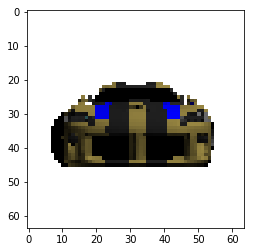

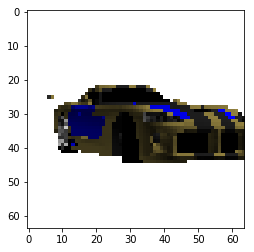

In [13]:
print(batch.shape, batch_labels.shape, pose_labels.shape)

t = 6
print(pose_labels[t][0][0])

plt.imshow(batch[t]/255)
plt.show()
plt.imshow(batch_labels[t]/255)
plt.show()


In [14]:
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x)

def normalize(data):
    data /= 255
    return data


def conv2d(input, output, kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2d", act=lrelu):
    #act = tf.nn.leaky_relu
    with tf.variable_scope(scope_name):
        return layers.conv2d(inputs=input, num_outputs=output, kernel_size=[kernel_h, kernel_w], stride=k_stride, activation_fn=act,
         biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02))
    
def deconv2d(input, kernel_size, stride, num_filter, scope_name='deconv2d', act=lrelu):
    with tf.variable_scope(scope_name): 
        stride_shape = [stride, stride]
        kernel_shape = [kernel_size, kernel_size]
        return layers.conv2d_transpose(inputs=input, num_outputs=num_filter, stride=stride_shape, kernel_size= kernel_shape,
            padding='SAME', biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02),
            activation_fn=act
        )

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')


def batch_norm(inputs_, is_training):
    out = tf.contrib.layers.batch_norm(inputs_, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def l1_loss(inputs_, targets_):
    loss = tf.reduce_mean(abs(inputs_ - targets_))
    return loss

def ce_loss(labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)
    

In [15]:
tf.reset_default_graph()

In [16]:
batch_size = 36
# tf Graph input (only pictures)
inputs_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")
targets_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="target")
pose_ = tf.placeholder(tf.float32, (batch_size, 8, 8, 36), name="pose")

disc_inputs = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")

real_label = tf.placeholder(tf.float32, [batch_size, 1])
fake_label = tf.placeholder(tf.float32, [batch_size, 1])

In [17]:
ae_reuse= False
disc_reuse = False

#generate coarse images from inputs_
def auto_encoder(inputs_, pose_):
    print(inputs_)
    global ae_reuse
    with tf.variable_scope('encoder', reuse=ae_reuse):
        ae_reuse = True
        _ = conv2d(inputs_, output=16 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv1",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=92 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv3",act=lrelu)
        _ = tf.concat([pose_, _], 3)

        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=32, scope_name='deconv1',act=lrelu)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=16, scope_name='deconv2',act=lrelu)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=3, scope_name='deconv3',act=lrelu)
        _ = tf.sigmoid(_)
    return _ 
    
    
# discriminator should give a fc layer
def discriminator(inputs_):
    global disc_reuse 
    with tf.variable_scope('dis', reuse=disc_reuse):
        disc_reuse = True
        ''' 
        _ = conv2d(inputs_, 4, 2, 32, 'conv1')
        _ = leaky_relu(_)
        _ = conv2d(_, 4, 2, 64, 'conv2')
        _ = batch_norm(_)
        _ = leaky_relu(_)
        _ = conv2d(_, 4, 2, 128, 'conv3')
        _ = batch_norm(_)
        _ = leaky_relu(_)
        _ = tf.reshape(_, [-1, 4 * 4 * 128])
        _ = fc(_, 1, 'fc4')
        print(_.get_shape(), "FC - Result")
        '''
        
        _ = conv2d(inputs_, output=16 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="dis_conv1", act=lrelu)
        _ = conv2d(_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="dis_conv2", act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="dis_conv3", act=lrelu)
        _ = batch_norm(_, True)
        _ = tf.reshape(_, [-1, 8 * 8 * 32])        
        _ = fc(_, 1, 'dis_fc1')
        return _


In [18]:
global_step = tf.Variable(0,trainable=False)
lr = 3e-4

In [19]:
alpha = 0
beta = 1.0

generated_images = auto_encoder(inputs_, pose_)
dis_fake_samples_op = discriminator(generated_images)

gen_loss_op = (alpha * ce_loss(real_label, dis_fake_samples_op)) + (beta * l1_loss(generated_images, targets_))
dis_loss_op = ce_loss(fake_label, dis_fake_samples_op) + ce_loss(real_label, discriminator(disc_inputs))

Tensor("input:0", shape=(36, 64, 64, 3), dtype=float32)


In [20]:
disriminator_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
generator_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'encoder')
#print (generator_vars)
dis_optimizer = tf.train.RMSPropOptimizer(lr)
dis_train_op = dis_optimizer.minimize(dis_loss_op, var_list=disriminator_vars)

gen_optimizer = tf.train.RMSPropOptimizer(lr)
gen_train_op = gen_optimizer.minimize(gen_loss_op, var_list=generator_vars)

In [22]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 3
total_images = len(train_pairs)
step = 0

r = total_images // batch_size
l = len(dataset_train) // batch_size
#print(data_train.shape, "X1")
#d_inputs = data_train[399*batch_size : (400)*batch_size]
#print(d_inputs.shape, "X2")



for epoch in range(epochs):
    for ii in range(1000):
        step += 1
        zeros = np.zeros([batch_size, 1])
        ones = np.ones([batch_size, 1])
        
        #batch = data_train[ii*batch_size : (ii+1)*batch_size]
        #batch_labels = train_labels[ii*batch_size : (ii+1)*batch_size]
        #pose_labels = pose[ii*batch_size : (ii+1)*batch_size]
        
        d_pairs = train_pairs[ii*batch_size : (ii+1)*batch_size]
        batch, batch_labels, pose_labels = get_batch_data(d_pairs)
        batch = normalize(batch)
        batch_labels = normalize(batch_labels)
        
        '''
        print(pose_labels[0][0][0])
        plt.imshow(batch[0])
        plt.show()
        plt.imshow(batch_labels[0])
        plt.show()
        '''
        
        k = np.random.randint(1,l-1)
        d_inputs = dataset_train[k*batch_size : (k+1)*batch_size]

        gen_feed_dict = {inputs_: batch, targets_: batch_labels, pose_: pose_labels,
                         real_label: ones}
        _, gen_loss = sess.run([gen_train_op, gen_loss_op], feed_dict = gen_feed_dict)
        
        
        dis_feed_dict = {inputs_: batch, targets_: batch_labels, pose_: pose_labels,
                         fake_label: zeros, real_label: ones, disc_inputs: d_inputs}
        _, dis_loss = sess.run([dis_train_op, dis_loss_op], feed_dict = dis_feed_dict)

        if step % 100 == 0:
            print('Step {0}: dis loss = {1:.4f}, gen loss = {2:.4f}'.format(step, dis_loss, gen_loss))
            
    print('Epoch {0}: dis loss = {1:.4f}, gen loss = {2:.4f}'.format(epoch, dis_loss, gen_loss))

Step 100: dis loss = 0.0011, gen loss = 0.4538
Step 200: dis loss = 0.0000, gen loss = 0.4481
Step 300: dis loss = 0.0000, gen loss = 0.1251
Step 400: dis loss = 0.0000, gen loss = 0.1105
Step 500: dis loss = 0.0000, gen loss = 0.0968
Step 600: dis loss = 0.0000, gen loss = 0.0956
Step 700: dis loss = 0.0000, gen loss = 0.0884
Step 800: dis loss = 0.0000, gen loss = 0.0925
Step 900: dis loss = 0.0000, gen loss = 0.0955
Step 1000: dis loss = 0.0000, gen loss = 0.0879
Epoch 0: dis loss = 0.0000, gen loss = 0.0879
Step 1100: dis loss = 0.0000, gen loss = 0.0971
Step 1200: dis loss = 0.0000, gen loss = 0.1040
Step 1300: dis loss = 0.0000, gen loss = 0.0964
Step 1400: dis loss = 0.0000, gen loss = 0.0942
Step 1500: dis loss = 0.0000, gen loss = 0.0895
Step 1600: dis loss = 0.0000, gen loss = 0.0874
Step 1700: dis loss = 0.0000, gen loss = 0.0794
Step 1800: dis loss = 0.0000, gen loss = 0.0860
Step 1900: dis loss = 0.0000, gen loss = 0.0873
Step 2000: dis loss = 0.0000, gen loss = 0.0811
Epo

In [23]:
dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'encoder')
saver = tf.train.Saver(dis_var_list + gen_var_list)
saver.save(sess, 'model/gan_pose_car_op_one_pose')

'model/gan_pose_car_op_one_pose'

In [24]:
cur_pose =  np.zeros(36, dtype='uint8')
cur_pose[5] = 1
pose = [np.broadcast_to(cur_pose,(8,8,36)) for i in range(batch_size)]
pose = np.array(pose, dtype=np.float32)

In [48]:
d_pairs = test_pairs[36 : 72]
test_batch, test_labels, test_pose = get_batch_data(d_pairs)

In [49]:
feed_dict = { inputs_: test_batch, pose_: test_pose}
op = sess.run([generated_images], feed_dict = feed_dict)

(64, 64, 3)


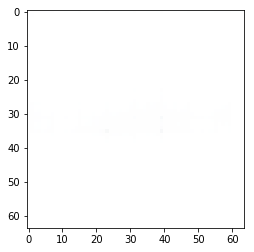

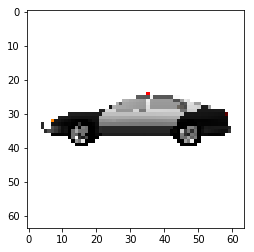

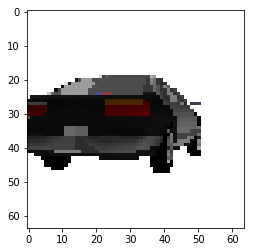

(64, 64, 3)


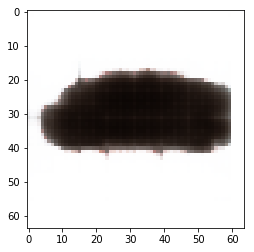

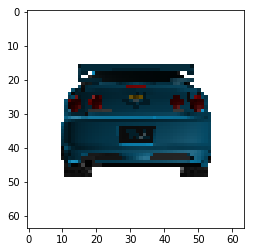

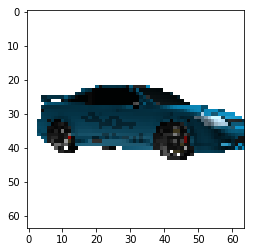

(64, 64, 3)


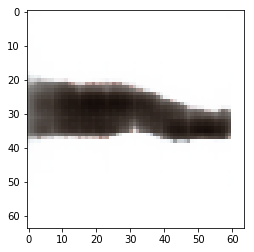

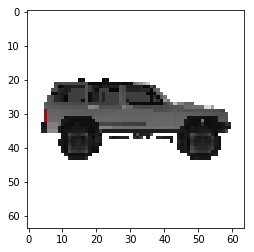

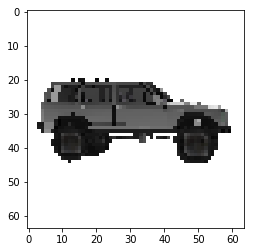

(64, 64, 3)


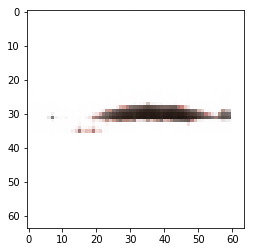

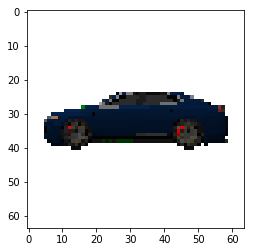

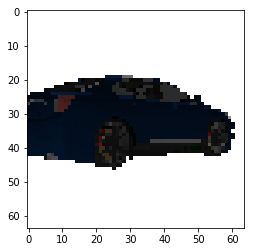

(64, 64, 3)


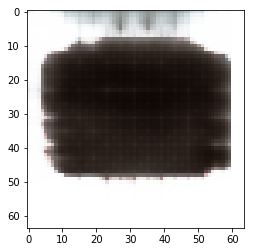

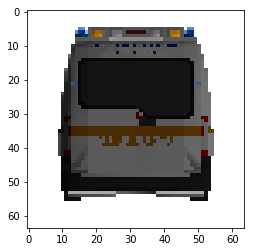

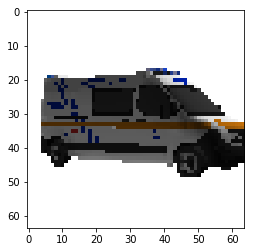

(64, 64, 3)


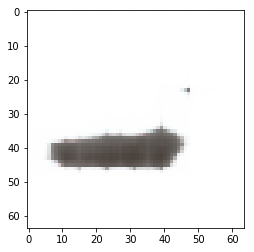

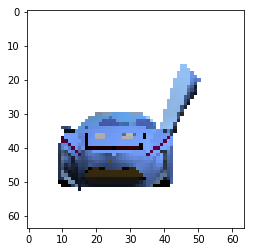

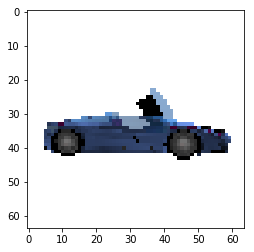

(64, 64, 3)


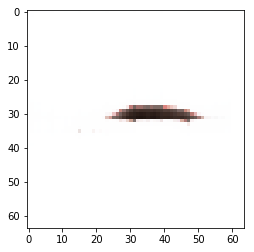

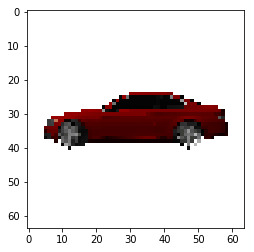

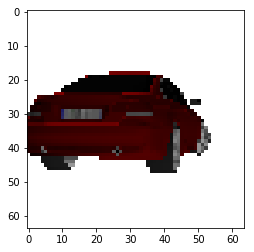

(64, 64, 3)


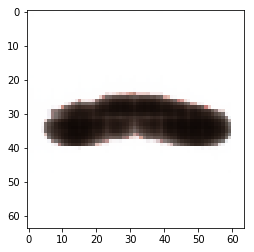

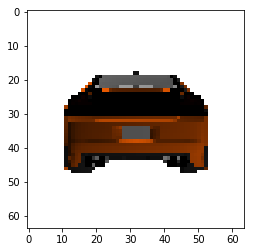

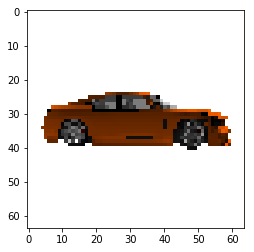

(64, 64, 3)


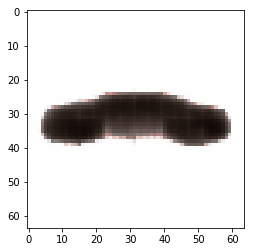

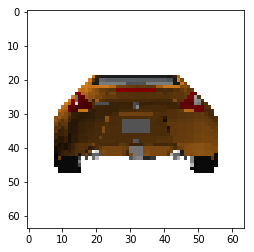

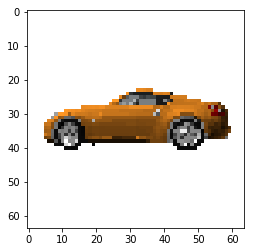

(64, 64, 3)


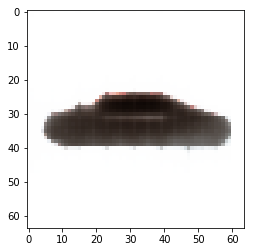

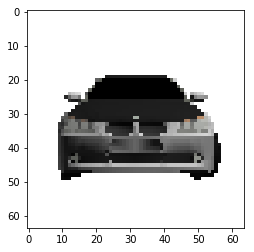

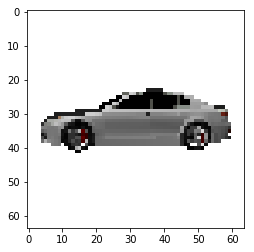

(64, 64, 3)


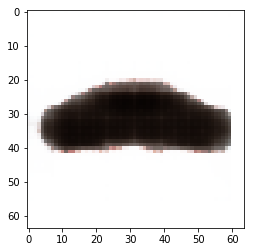

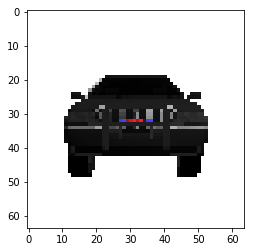

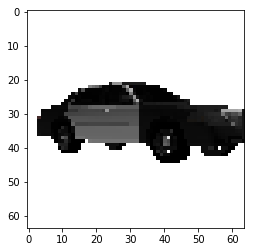

(64, 64, 3)


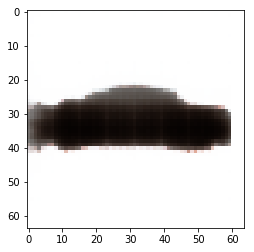

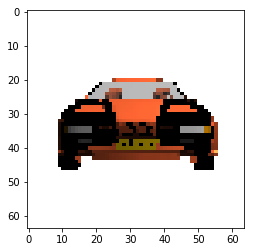

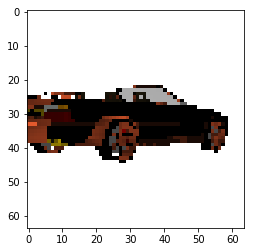

(64, 64, 3)


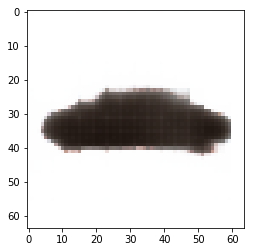

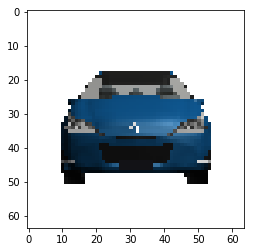

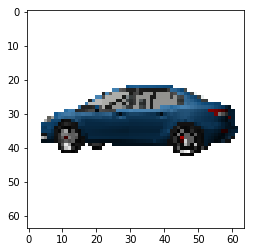

(64, 64, 3)


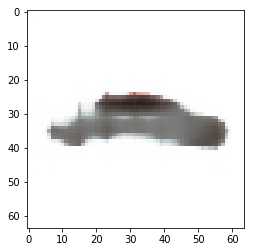

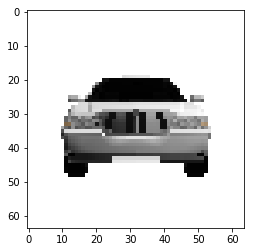

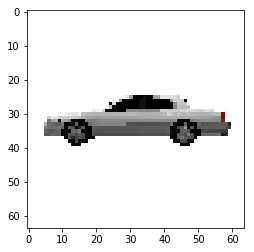

(64, 64, 3)


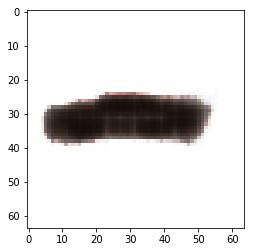

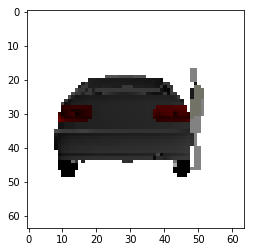

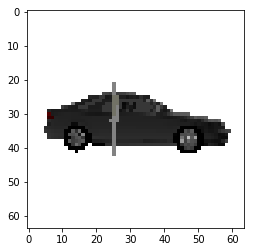

(64, 64, 3)


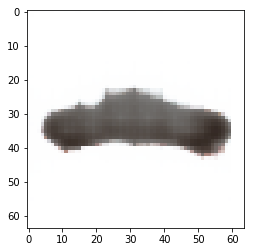

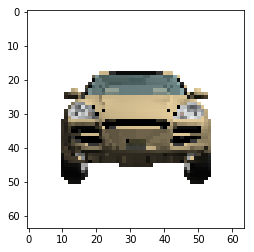

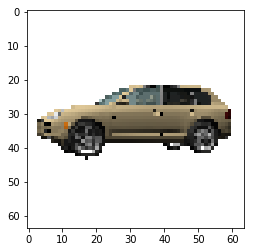

(64, 64, 3)


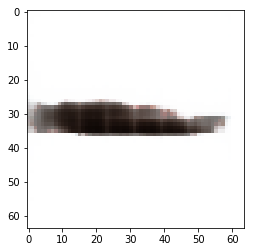

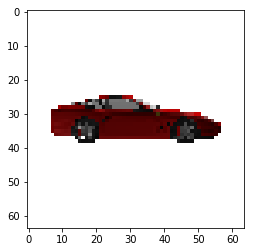

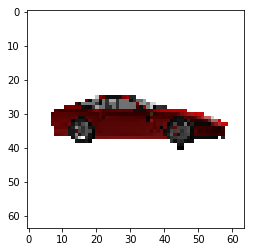

(64, 64, 3)


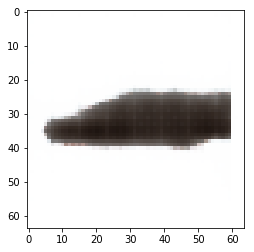

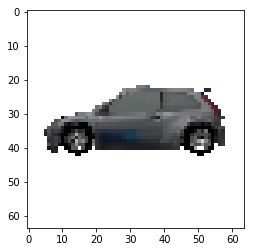

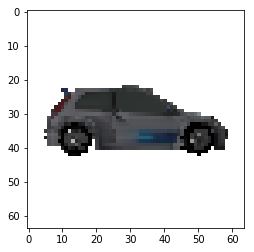

(64, 64, 3)


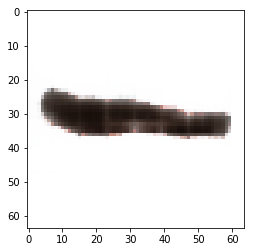

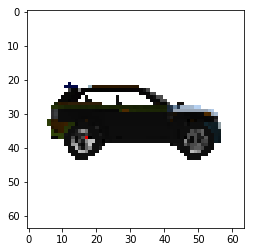

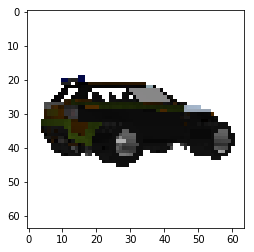

(64, 64, 3)


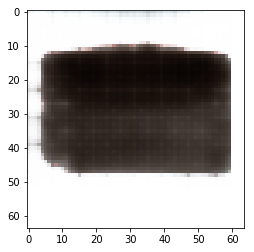

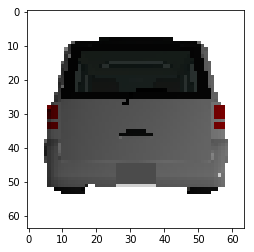

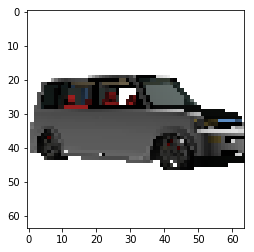

(64, 64, 3)


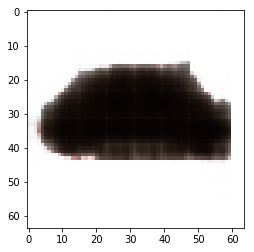

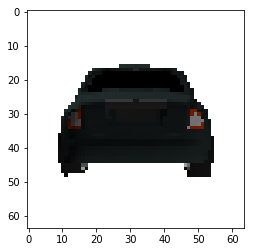

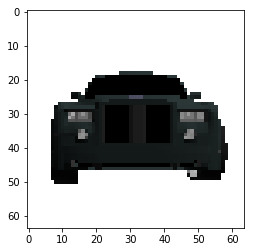

(64, 64, 3)


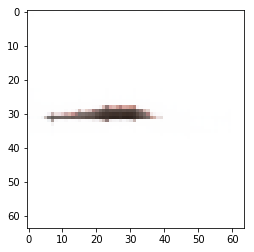

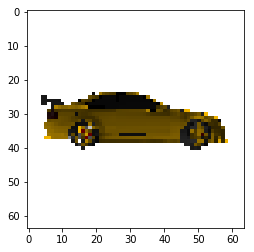

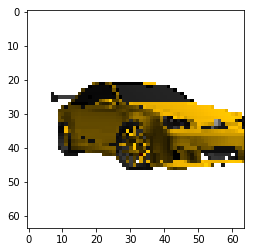

(64, 64, 3)


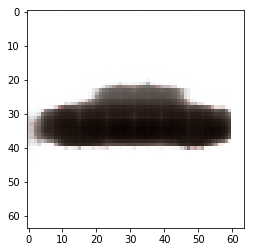

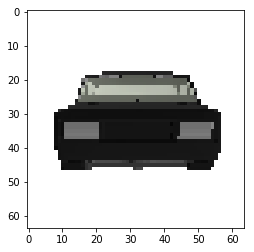

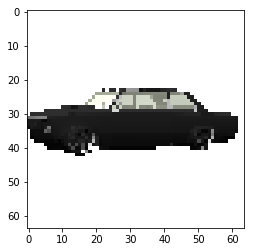

(64, 64, 3)


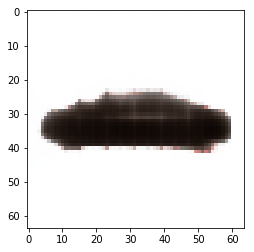

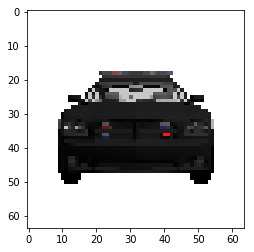

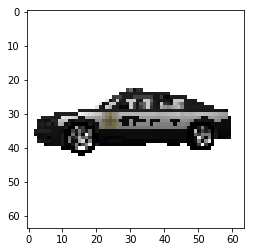

(64, 64, 3)


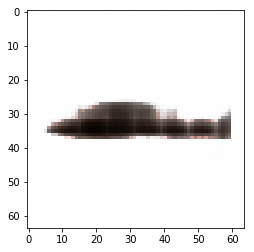

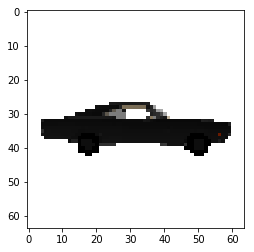

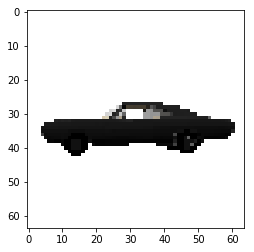

(64, 64, 3)


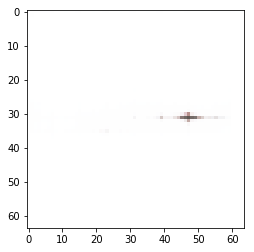

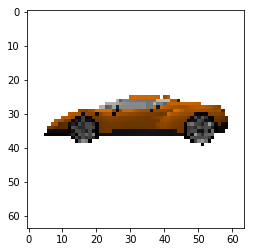

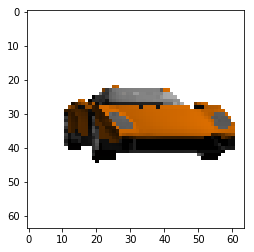

(64, 64, 3)


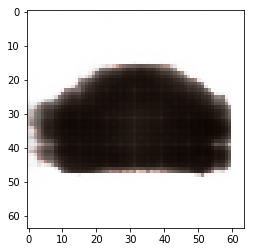

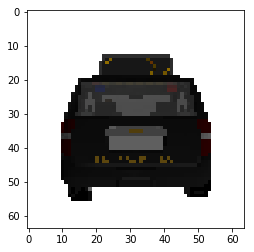

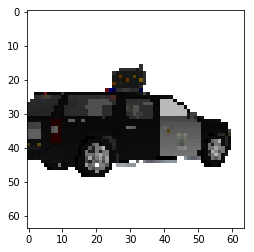

(64, 64, 3)


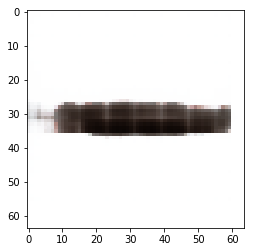

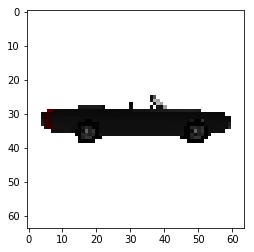

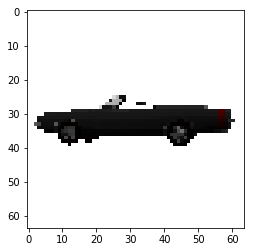

(64, 64, 3)


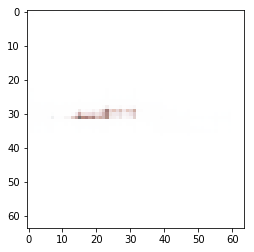

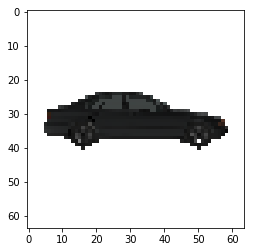

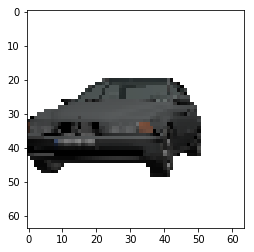

(64, 64, 3)


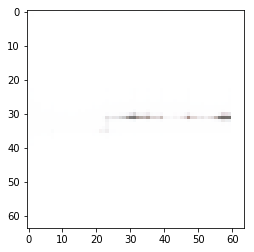

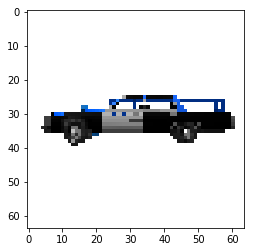

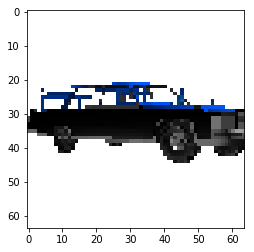

(64, 64, 3)


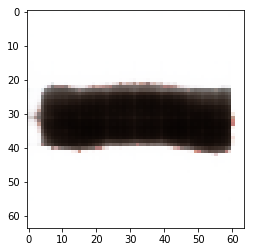

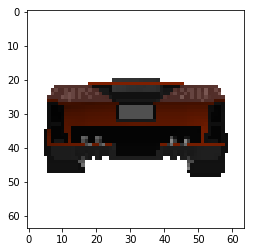

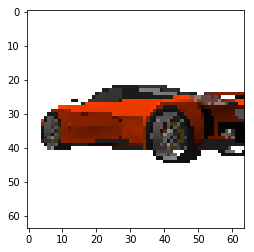

(64, 64, 3)


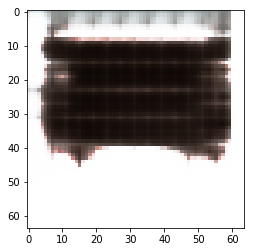

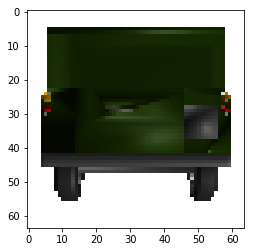

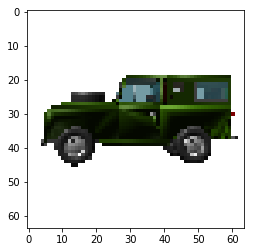

(64, 64, 3)


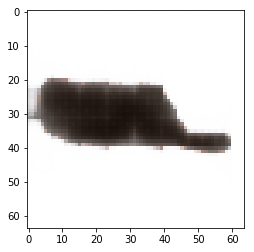

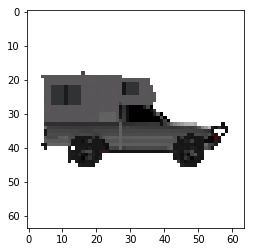

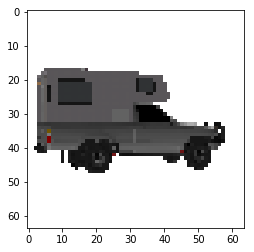

(64, 64, 3)


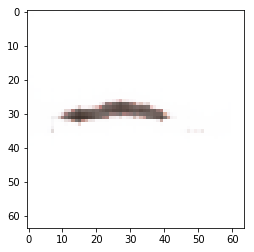

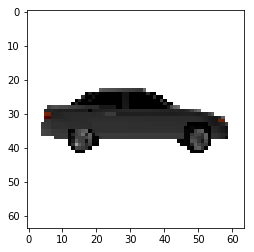

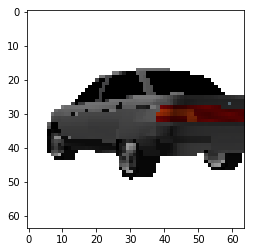

(64, 64, 3)


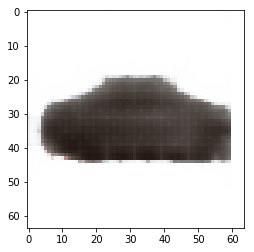

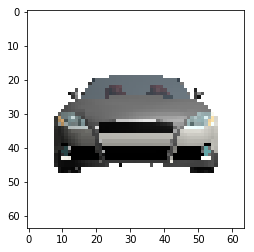

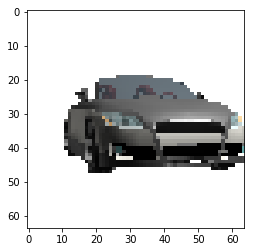

(64, 64, 3)


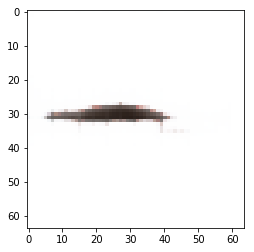

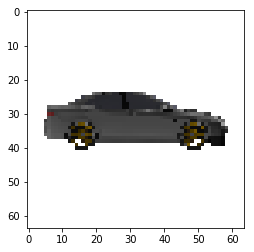

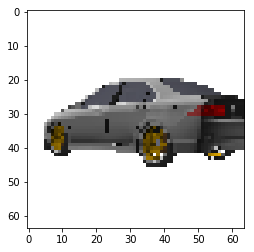

In [50]:
j = 20
for j in range(36):
    tmp = op[0][j]
    print(tmp.shape)

#print(np.max(tmp), np.min(tmp))
    plt.imshow(tmp)
    plt.show()

    plt.imshow(test_batch[j]/255)
    plt.show()

    plt.imshow(test_labels[j]/255)
    plt.show()